In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from wordcloud import WordCloud

In [3]:
os.chdir('..')

In [4]:
from src.loader import NewsDataLoader
import src.countries_region as countries_region 

In [5]:
from src.config import cfg

Output File: news_output.csv
Path: data
News Data: rating.csv
Traffic Data: trafiic.csv
Domain Location Data: domains_location.csv


In [6]:
import src.utils as utils

In [7]:
news_data_loader = NewsDataLoader(cfg.path)

In [8]:
# get news csv file
news = news_data_loader.get_news()

# get traffic csv file
traffic = news_data_loader.get_traffic()

# get domain location data csv file
domain = news_data_loader.get_domain_location()

In [9]:
df = pd.read_csv(news)
traffic_df = pd.read_csv(traffic)
domain_df = pd.read_csv(domain)

In [10]:
df.shape

(58356, 13)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58356 entries, 0 to 58355
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   article_id       58356 non-null  int64 
 1   source_id        17771 non-null  object
 2   source_name      58356 non-null  object
 3   author           56193 non-null  object
 4   title            58356 non-null  object
 5   description      58346 non-null  object
 6   url              58356 non-null  object
 7   url_to_image     54905 non-null  object
 8   published_at     58356 non-null  object
 9   content          58356 non-null  object
 10  category         58335 non-null  object
 11  article          58356 non-null  object
 12  title_sentiment  58356 non-null  object
dtypes: int64(1), object(12)
memory usage: 5.8+ MB


In [12]:
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   GlobalRank      1000000 non-null  int64 
 1   TldRank         1000000 non-null  int64 
 2   Domain          1000000 non-null  object
 3   TLD             1000000 non-null  object
 4   RefSubNets      1000000 non-null  int64 
 5   RefIPs          1000000 non-null  int64 
 6   IDN_Domain      1000000 non-null  object
 7   IDN_TLD         1000000 non-null  object
 8   PrevGlobalRank  1000000 non-null  int64 
 9   PrevTldRank     1000000 non-null  int64 
 10  PrevRefSubNets  1000000 non-null  int64 
 11  PrevRefIPs      1000000 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 91.6+ MB


In [13]:
domain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37802 entries, 0 to 37801
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   SourceCommonName  37802 non-null  object
 1   location          37802 non-null  object
 2   Country           37801 non-null  object
dtypes: object(3)
memory usage: 886.1+ KB


In [14]:
df.isna().sum()

article_id             0
source_id          40585
source_name            0
author              2163
title                  0
description           10
url                    0
url_to_image        3451
published_at           0
content                0
category              21
article                0
title_sentiment        0
dtype: int64

In [15]:
domain_df.isna().sum()

SourceCommonName    0
location            0
Country             1
dtype: int64

In [16]:

traffic_df.isna().sum()

GlobalRank        0
TldRank           0
Domain            0
TLD               0
RefSubNets        0
RefIPs            0
IDN_Domain        0
IDN_TLD           0
PrevGlobalRank    0
PrevTldRank       0
PrevRefSubNets    0
PrevRefIPs        0
dtype: int64

In [51]:
df.dropna(subset=['category'], inplace=True)

domain_df.dropna(subset=['Country'], inplace=True)

# remove duplicates
df = df.loc[~df.duplicated(subset=['article_id','url', 'published_at'])].reset_index(drop=True)

# drop rows with unnesessary columns
df = df[['article_id', 
# 'source_id', 
'source_name', 
# 'author', 
'title',
'description', 'url', 
# 'url_to_image', 
'published_at', 'content',
'category', 'article', 'title_sentiment']]
df.columns

Index(['article_id', 'source_name', 'title', 'description', 'url',
       'published_at', 'content', 'category', 'article', 'title_sentiment'],
      dtype='object')

In [22]:
df.isna().sum()

article_id         0
source_name        0
title              0
description        9
url                0
published_at       0
content            0
category           0
article            0
title_sentiment    0
dtype: int64

In [23]:
traffic_df.isna().sum()

GlobalRank        0
TldRank           0
Domain            0
TLD               0
RefSubNets        0
RefIPs            0
IDN_Domain        0
IDN_TLD           0
PrevGlobalRank    0
PrevTldRank       0
PrevRefSubNets    0
PrevRefIPs        0
dtype: int64

In [24]:
domain_df.isna().sum()

SourceCommonName    0
location            0
Country             0
dtype: int64

In [25]:
df.head()

article_id     source_name  \
0       81664          Forbes   
1       81667             CNA   
2       81694            Time   
3       81695        Phys.Org   
4       81703  Digital Trends   

                                               title  \
0  superstar chef yannick alléno brings refined f...   
1  nice claim top spot in ligue 1 with late win a...   
2  amphibians are the world’s most vulnerable spe...   
3              image: rusty red waters in madagascar   
4  everything leaving max (formerly hbo max) in n...   

                                         description  \
0  Now open in Mayfair at Four Seasons Hotel Lond...   
1  Nice moved into provisional first place in the...   
2  The world’s frogs, salamanders, newts, and oth...   
3  Iron-rich sediment colors the red-orange water...   
4  From Gangs of London to Fear the Walking Dead ...   

                                                 url  \
0  https://www.forbes.com/sites/elizabethbrownfie...   
1  https://www.channelnewsasia.com/sport/nice-cla...   
2  https://time.com/6320467/amphibians-most-vulne...   
3  https://phys.org/news/2023-10-image-rusty-red-...   
4  https://www.digitaltrends.com/movies/everythin...   

                 published_at  \
0  2023-11-01 03:27:21.000000   
1  2023-10-27 21:28:48.000000   
2  2023-10-04 17:36:18.000000   
3  2023-10-31 18:04:02.000000   
4  2023-10-23 23:09:18.000000   

                                             content    category  \
0  Pavyllon London, at Four Seasons Hotel London ...      Monaco   
1  Nice moved into provisional first place in the...      Monaco   
2  The worlds frogs, salamanders, newts and other...  Madagascar   
3  Iron-rich sediment colors the red-orange water...  Madagascar   
4  Everything ends. No, I’m not having an existen...  Madagascar   

                                             article title_sentiment  
0  pavyllon london, at four seasons hotel london ...         Neutral  
1  nice moved into provisional first place in the...        Positive  
2  the world’s frogs, salamanders, newts and othe...        Negative  
3  iron-rich sediment colors the red-orange water...         Neutral  
4  everything ends. no, i’m not having an existen...         Neutral

In [26]:
domain_df.head()

SourceCommonName location    Country
0       00221.info       SG    Senegal
1        01net.com       FR     France
2         01net.it       IT      Italy
3      0223.com.ar       AR  Argentina
4     022china.com       CH      China

In [27]:
traffic_df.head()

GlobalRank  TldRank         Domain  TLD  RefSubNets   RefIPs  \
0           1        1     google.com  com      471274  2151358   
1           2        2   facebook.com  com      465424  2250631   
2           3        3    youtube.com  com      420579  1852995   
3           4        4    twitter.com  com      404985  1757127   
4           5        5  instagram.com  com      364746  1598085   

      IDN_Domain IDN_TLD  PrevGlobalRank  PrevTldRank  PrevRefSubNets  \
0     google.com     com               1            1          471248   
1   facebook.com     com               2            2          465297   
2    youtube.com     com               3            3          420483   
3    twitter.com     com               4            4          404998   
4  instagram.com     com               5            5          364618   

   PrevRefIPs  
0     2147402  
1     2247135  
2     1848940  
3     1753939  
4     1594892

In [62]:
df['domain'] = df['url'].apply(utils.get_domain)
# df.head()

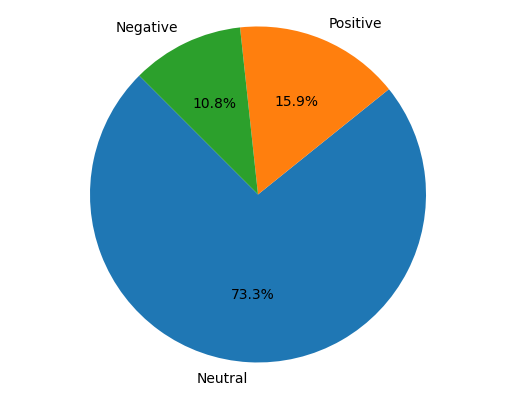

In [152]:
df["title_sentiment"].value_counts()
plt.pie(df['title_sentiment'].value_counts(), labels=df['title_sentiment'].unique(), autopct='%1.1f%%', startangle=135)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

The Pie Chart above illustrates that 73.6% of the post made by all news media were neutral, while 15.6% are positive and only 10.8% of their news are negative. Showing that globaly mostly are neutral news being reported.

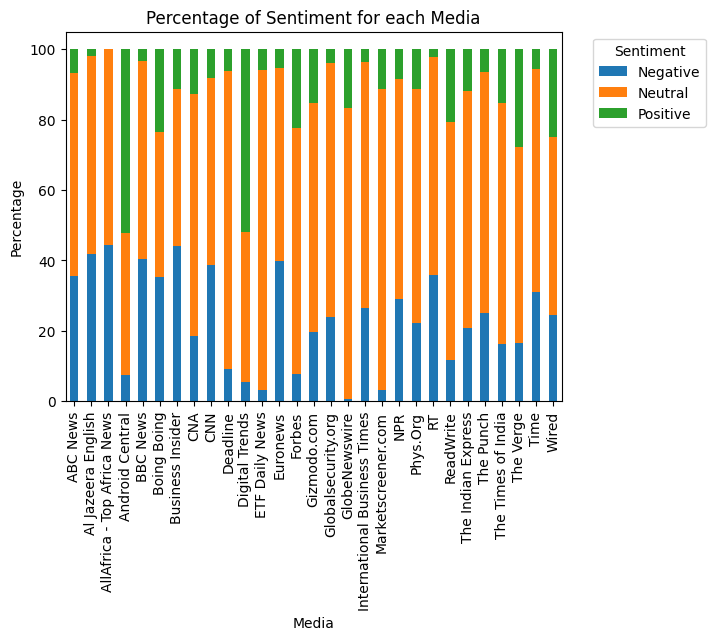

In [64]:
sentiment_counts = df.groupby(['source_name', 'title_sentiment']).size().unstack(fill_value=0)
sentiment_percentages = sentiment_counts.div(sentiment_counts.sum(axis=1, numeric_only=True), axis=0) * 100

# Plot the bar graph
sentiment_percentages.plot(kind='bar', stacked=True)
plt.xlabel('Media')
plt.ylabel('Percentage')
plt.title('Percentage of Sentiment for each Media')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

The bars above show that more than 40% of business insider's post were mostly negative news with neutral news having almost the same percentage of polarity and with the lowest positive news. Majority of Android Central's news were positive while the majority of ETF Dailyis neutral with one of the least negative as well as positive news reported and almost supprisingly All Africa has little or no positive news

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54562 entries, 0 to 54561
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   article_id       54562 non-null  int64 
 1   source_name      54562 non-null  object
 2   title            54562 non-null  object
 3   description      54553 non-null  object
 4   url              54562 non-null  object
 5   published_at     54562 non-null  object
 6   content          54562 non-null  object
 7   category         54562 non-null  object
 8   article          54562 non-null  object
 9   title_sentiment  54562 non-null  object
 10  domain           54562 non-null  object
dtypes: int64(1), object(10)
memory usage: 4.6+ MB


In [192]:
# Count the number of articles per source_name
article_counts = df['source_name'].value_counts()

# Get the top 10 websites
top_10_websites = article_counts.head(10)

# Get the bottom 10 websites
bottom_10_websites = article_counts.tail(10)

In [193]:
print("Top 10 websites with the largest count of news articles:")
print(top_10_websites)

Top 10 websites with the largest count of news articles:
ETF Daily News        15035
The Times of India     7006
GlobeNewswire          5040
Globalsecurity.org     2904
Forbes                 2574
BBC News               2018
Business Insider       1978
ABC News               1946
The Punch              1748
Al Jazeera English     1587
Name: source_name, dtype: int64


In [194]:

print("\nBottom 10 websites with the smallest count of news articles:")
print(bottom_10_websites)


Bottom 10 websites with the smallest count of news articles:
CNA                            671
Time                           579
Android Central                515
Gizmodo.com                    380
ReadWrite                      315
Euronews                       286
Wired                          256
CNN                            256
The Verge                      205
AllAfrica - Top Africa News     18
Name: source_name, dtype: int64


In [186]:
domain_df.columns

country_merged_df = df.merge(domain_df[['SourceCommonName', 'Country']], left_on='domain', right_on='SourceCommonName', how='left')

# # Drop the extra 'Domain' column
country_merged_df = country_merged_df.drop(columns='SourceCommonName')

# Rename the 'GlobalRank' column to 'global_rank'
country_merged_df = country_merged_df.rename(columns={'Country': 'country'})

In [191]:
# Countries with the highest number of news media organisations (represented by domains in the data)
top10 = country_merged_df['country'].value_counts().head(100)

bottom10 = country_merged_df['country'].value_counts().tail(10)

print("Top 10 countries with the highest number of news media organisations:\n")
print(top10)
print("\n\nBottom 10 countries with the lowest number of news media organisations:\n")
print(bottom10)


Top 10 countries with the highest number of news media organisations:

United States     37925
United Kingdom     2018
Nigeria            1766
India              1116
Russia             1086
Name: country, dtype: int64


Bottom 10 countries with the lowest number of news media organisations:

United States     37925
United Kingdom     2018
Nigeria            1766
India              1116
Russia             1086
Name: country, dtype: int64


In [69]:
# Countries that have many articles written about them
category = df['category'].value_counts()
countries = domain_df['Country'].unique()
country_categories = category[category.index.isin(countries)]
print("Top 10\n")
print(country_categories.head(10))
print("\nBottom 10\n")
print(country_categories.tail(10))

Top 10

Canada            1902
India             1000
Australia          841
United Kingdom     724
Ukraine            556
Mexico             537
Nigeria            469
United States      469
Germany            434
Hong Kong          419
Name: category, dtype: int64

Bottom 10

Turkmenistan    8
Montserrat      7
Bhutan          7
Eritrea         6
San Marino      4
Gambia          4
Andorra         3
Burundi         3
Honduras        3
Martinique      2
Name: category, dtype: int64


In [195]:
# Websites that reported (the news content) about Africa
region = countries_region.get_region()

df['Region'] = df['category'].map(region)

africa = df[df['Region'] == 'Africa']['source_name'].value_counts().head(10)

# Websites that reported (the news content) about Europe

europe = df[df['Region'] == 'Europe']['source_name'].value_counts().head(10)

# Websites that reported (the news content) about Asia

asia = df[df['Region'] == 'Asia']['source_name'].value_counts().head(10)

# Websites that reported (the news content) about North America

north_america = df[df['Region'] == 'America']['source_name'].value_counts().head(10)

# Websites that reported (the news content) about China

china = df[df['Region'] == 'China']['source_name'].value_counts().head(10)


In [196]:


print("Top 10 websites that reported news content about Africa:\n")
print(africa)

Top 10 websites that reported news content about Africa:

The Punch                       835
Marketscreener.com              242
The Times of India              196
Globalsecurity.org              189
ETF Daily News                  182
BBC News                        138
RT                              129
Al Jazeera English              116
ABC News                        105
International Business Times     97
Name: source_name, dtype: int64


In [197]:

print("\nTop 10 websites that reported news content about Europe:\n")
print(europe)


Top 10 websites that reported news content about Europe:

ETF Daily News        934
GlobeNewswire         476
Globalsecurity.org    465
RT                    246
The Times of India    232
ABC News              198
Business Insider      191
Al Jazeera English    178
Euronews              147
BBC News              120
Name: source_name, dtype: int64


In [198]:

print("\nTop 10 websites that reported news content about Asia:\n")
print(asia)


Top 10 websites that reported news content about Asia:

The Times of India              1379
Globalsecurity.org               578
Al Jazeera English               372
ETF Daily News                   351
CNA                              270
ABC News                         241
GlobeNewswire                    219
RT                               201
The Indian Express               201
International Business Times     179
Name: source_name, dtype: int64


In [199]:

print("\nTop 10 websites that reported news content about North America:\n")
print(north_america)


Top 10 websites that reported news content about North America:

ETF Daily News        374
Business Insider       50
GlobeNewswire          35
ABC News               25
Forbes                 20
The Times of India     15
NPR                    14
Boing Boing            14
Time                   12
Marketscreener.com     10
Name: source_name, dtype: int64


In [200]:

print("\nTop 10 websites that reported news content about China:\n")
print(china)


Top 10 websites that reported news content about China:

Globalsecurity.org              107
ETF Daily News                   77
The Times of India               63
International Business Times     21
RT                               20
Al Jazeera English               17
GlobeNewswire                    15
Business Insider                 15
Time                              9
Forbes                            7
Name: source_name, dtype: int64


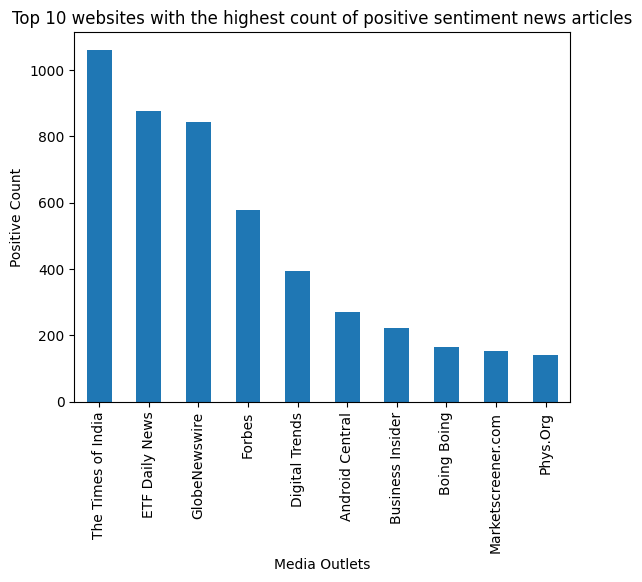

In [145]:
# Group by website and sentiment and count the number of articles
website_sentiment_counts = df.groupby(['source_name', 'title_sentiment']).size()

# Get the top 10 websites with the highest count of positive sentiments
top_positive_websites = website_sentiment_counts.loc[:, 'Positive'].nlargest(10)

top_positive_websites.plot(kind='bar')
plt.xlabel('Media Outlets')
plt.ylabel('Positive Count')
plt.title('Top 10 websites with the highest count of positive sentiment news articles')
plt.show()

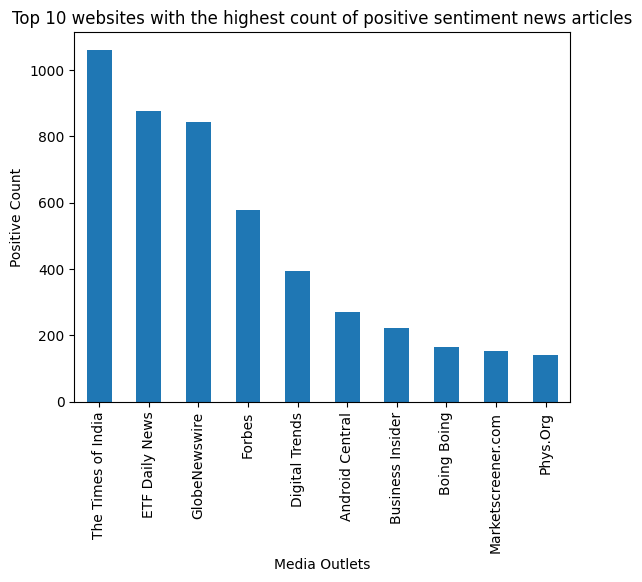

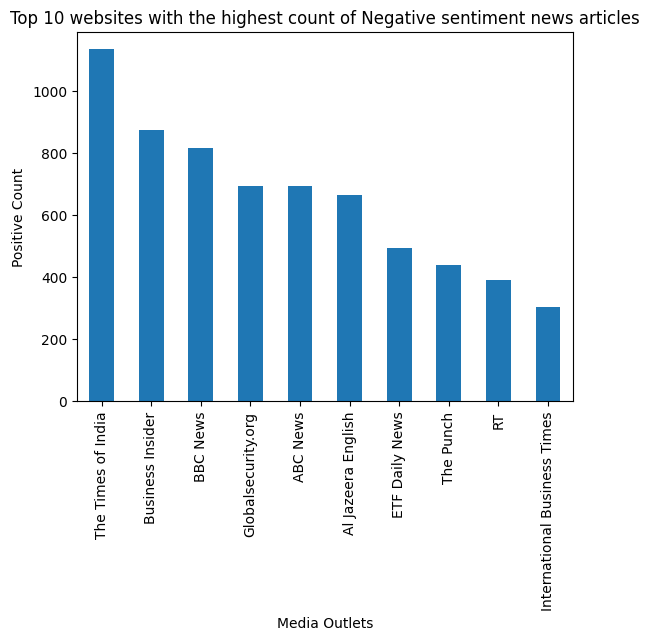

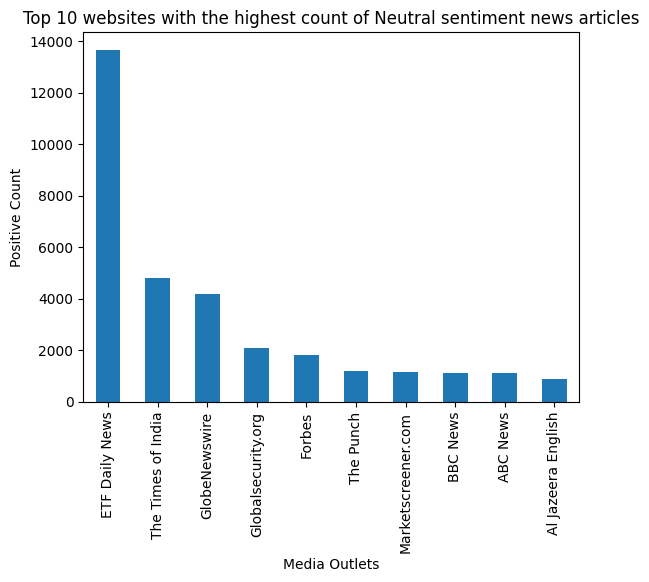

In [105]:
#Websites with the highest count of positive sentiment news articles
positive = df[df['title_sentiment'] == 'Positive']['source_name'].value_counts().head(10)

#websites with the highest count of negative sentiment news articles
negative = df[df['title_sentiment'] == 'Negative']['source_name'].value_counts().head(10)

#websites with the highest count of neutral sentiment news articles
neutral = df[df['title_sentiment'] == 'Neutral']['source_name'].value_counts().head(10)

# plot the top 10 websites with the highest count of positive sentiment news articles
positive.plot(kind='bar')
plt.xlabel('Media Outlets')
plt.ylabel('Positive Count')
plt.title('Top 10 websites with the highest count of positive sentiment news articles')
plt.show()


negative.plot(kind='bar')
plt.xlabel('Media Outlets')
plt.ylabel('Positive Count')
plt.title('Top 10 websites with the highest count of Negative sentiment news articles')
plt.show()

neutral.plot(kind='bar')
plt.xlabel('Media Outlets')
plt.ylabel('Positive Count')
plt.title('Top 10 websites with the highest count of Neutral sentiment news articles')
plt.show()

In [ ]:
print("Top 10 websites with the highest count of positive sentiment news articles:\n")
print(positive)
print("\nTop 10 websites with the highest count of negative sentiment news articles:\n")
print(negative)
print("\nTop 10 websites with the highest count of neutral sentiment news articles:\n")
print(neutral)

In [92]:
# calculate the sentiment score of the title
df['sentiment_score'] = df['title'].apply(utils.get_sentiment_score)

In [106]:

# Calculate the average or median sentiment for each website
average_sentiment = df.groupby('source_name')['sentiment_score'].mean()  

# or median sentiment
median_sentiment = df.groupby('source_name')['sentiment_score'].median()  

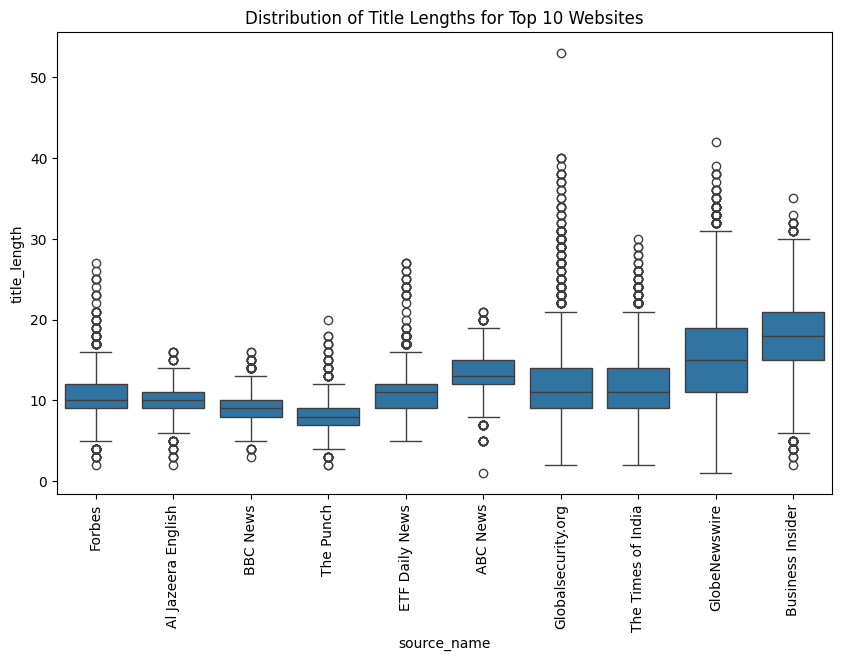

In [201]:
# How similar are the number of words in the title across sites? Check the distribution among sites
df['title_length'] = df['title'].apply(utils.get_number_of_words)
# df['title_length'].describe()

# How similar are the raw message lengths across sites?
website_title_counts = df.groupby('source_name')['title_length'].count()

# Get the top 10 websites with the highest number of articles
large_websites = website_title_counts.nlargest(10).index

# Filter the data to include only the top websites
websites_df = df[df['source_name'].isin(large_websites)]

# Plot the distribution of message lengths for each website
plt.figure(figsize=(10, 6))
sns.boxplot(x='source_name', y='title_length', data=websites_df)
plt.xticks(rotation=90)
plt.title('Distribution of Title Lengths for Top 10 Websites')
plt.show()

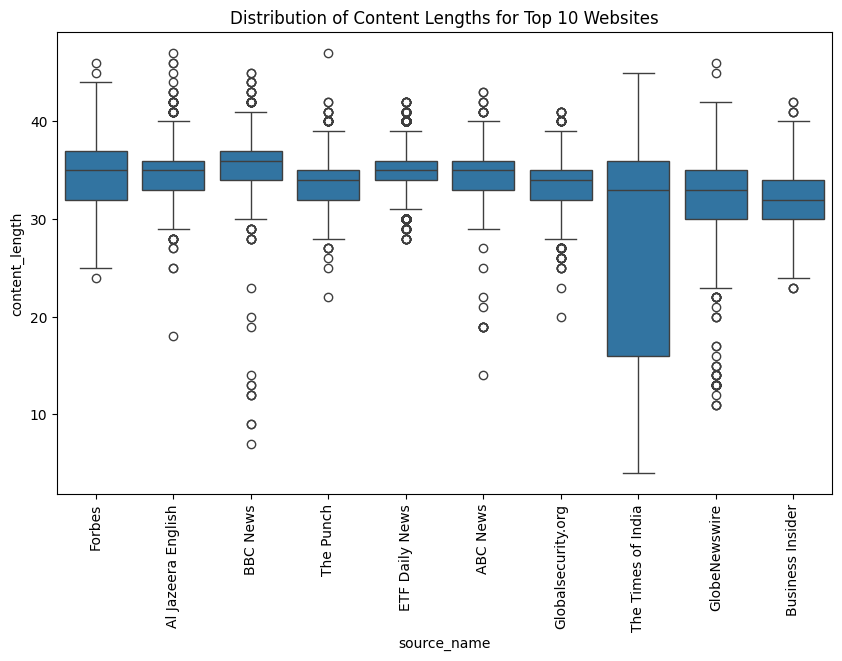

In [202]:
# How similar are the number of words in the title across sites? Check the distribution among sites
df['content_length'] = df['content'].apply(utils.get_number_of_words)

# How similar are the raw message lengths across sites?
website_article_counts = df.groupby('source_name')['content_length'].count()

# Get the top 10 websites with the highest number of articles
top_websites = website_article_counts.nlargest(10).index

# Filter the data to include only the top websites
top_websites_df = df[df['source_name'].isin(top_websites)]

# Plot the distribution of message lengths for each website
plt.figure(figsize=(10, 6))
sns.boxplot(x='source_name', y='content_length', data=top_websites_df)
plt.xticks(rotation=90)
plt.title('Distribution of Content Lengths for Top 10 Websites')
plt.show()
# df.groupby(df['source_name'].value_counts())['content_length'].mean().head(10)

In [129]:

df.columns

Index(['article_id', 'source_name', 'title', 'description', 'url',
       'published_at', 'content', 'category', 'article', 'title_sentiment',
       'domain', 'Region', 'sentiment_score', 'title_length',
       'content_length'],
      dtype='object')

In [134]:
merged_df = df.merge(traffic_df[['Domain', 'GlobalRank']], left_on='domain', right_on='Domain', how='left')

# Drop the extra 'Domain' column
merged_df = merged_df.drop(columns='Domain')

# Rename the 'GlobalRank' column to 'global_rank'
merged_df = merged_df.rename(columns={'GlobalRank': 'global_rank'})

merged_df.head()

article_id     source_name  \
0       81664          Forbes   
1       81667             CNA   
2       81694            Time   
3       81695        Phys.Org   
4       81703  Digital Trends   

                                               title  \
0  superstar chef yannick alléno brings refined f...   
1  nice claim top spot in ligue 1 with late win a...   
2  amphibians are the world’s most vulnerable spe...   
3              image: rusty red waters in madagascar   
4  everything leaving max (formerly hbo max) in n...   

                                         description  \
0  Now open in Mayfair at Four Seasons Hotel Lond...   
1  Nice moved into provisional first place in the...   
2  The world’s frogs, salamanders, newts, and oth...   
3  Iron-rich sediment colors the red-orange water...   
4  From Gangs of London to Fear the Walking Dead ...   

                                                 url  \
0  https://www.forbes.com/sites/elizabethbrownfie...   
1  https://www.channelnewsasia.com/sport/nice-cla...   
2  https://time.com/6320467/amphibians-most-vulne...   
3  https://phys.org/news/2023-10-image-rusty-red-...   
4  https://www.digitaltrends.com/movies/everythin...   

                 published_at  \
0  2023-11-01 03:27:21.000000   
1  2023-10-27 21:28:48.000000   
2  2023-10-04 17:36:18.000000   
3  2023-10-31 18:04:02.000000   
4  2023-10-23 23:09:18.000000   

                                             content    category  \
0  Pavyllon London, at Four Seasons Hotel London ...      Monaco   
1  Nice moved into provisional first place in the...      Monaco   
2  The worlds frogs, salamanders, newts and other...  Madagascar   
3  Iron-rich sediment colors the red-orange water...  Madagascar   
4  Everything ends. No, I’m not having an existen...  Madagascar   

                                             article title_sentiment  \
0  pavyllon london, at four seasons hotel london ...         Neutral   
1  nice moved into provisional first place in the...        Positive   
2  the world’s frogs, salamanders, newts and othe...        Negative   
3  iron-rich sediment colors the red-orange water...         Neutral   
4  everything ends. no, i’m not having an existen...         Neutral   

                domain  Region  sentiment_score  title_length  content_length  \
0           forbes.com  Europe           0.0000            11              34   
1  channelnewsasia.com  Europe           0.8126            12              37   
2             time.com  Africa          -0.6115            11              33   
3             phys.org  Africa           0.0000             6              35   
4    digitaltrends.com  Africa           0.0000             9              38   

   global_rank  
0         64.0  
1       1755.0  
2        137.0  
3        616.0  
4        711.0

In [135]:
merged_df.dropna(subset=['global_rank'], inplace=True)

merged_df.head(2)

article_id source_name                                              title  \
0       81664      Forbes  superstar chef yannick alléno brings refined f...   
1       81667         CNA  nice claim top spot in ligue 1 with late win a...   

                                         description  \
0  Now open in Mayfair at Four Seasons Hotel Lond...   
1  Nice moved into provisional first place in the...   

                                                 url  \
0  https://www.forbes.com/sites/elizabethbrownfie...   
1  https://www.channelnewsasia.com/sport/nice-cla...   

                 published_at  \
0  2023-11-01 03:27:21.000000   
1  2023-10-27 21:28:48.000000   

                                             content category  \
0  Pavyllon London, at Four Seasons Hotel London ...   Monaco   
1  Nice moved into provisional first place in the...   Monaco   

                                             article title_sentiment  \
0  pavyllon london, at four seasons hotel london ...         Neutral   
1  nice moved into provisional first place in the...        Positive   

                domain  Region  sentiment_score  title_length  content_length  \
0           forbes.com  Europe           0.0000            11              34   
1  channelnewsasia.com  Europe           0.8126            12              37   

   global_rank  
0         64.0  
1       1755.0

In [136]:
# convert the global_rank column to int
merged_df['global_rank'] = merged_df['global_rank'].astype(int)
merged_df.head()

article_id     source_name  \
0       81664          Forbes   
1       81667             CNA   
2       81694            Time   
3       81695        Phys.Org   
4       81703  Digital Trends   

                                               title  \
0  superstar chef yannick alléno brings refined f...   
1  nice claim top spot in ligue 1 with late win a...   
2  amphibians are the world’s most vulnerable spe...   
3              image: rusty red waters in madagascar   
4  everything leaving max (formerly hbo max) in n...   

                                         description  \
0  Now open in Mayfair at Four Seasons Hotel Lond...   
1  Nice moved into provisional first place in the...   
2  The world’s frogs, salamanders, newts, and oth...   
3  Iron-rich sediment colors the red-orange water...   
4  From Gangs of London to Fear the Walking Dead ...   

                                                 url  \
0  https://www.forbes.com/sites/elizabethbrownfie...   
1  https://www.channelnewsasia.com/sport/nice-cla...   
2  https://time.com/6320467/amphibians-most-vulne...   
3  https://phys.org/news/2023-10-image-rusty-red-...   
4  https://www.digitaltrends.com/movies/everythin...   

                 published_at  \
0  2023-11-01 03:27:21.000000   
1  2023-10-27 21:28:48.000000   
2  2023-10-04 17:36:18.000000   
3  2023-10-31 18:04:02.000000   
4  2023-10-23 23:09:18.000000   

                                             content    category  \
0  Pavyllon London, at Four Seasons Hotel London ...      Monaco   
1  Nice moved into provisional first place in the...      Monaco   
2  The worlds frogs, salamanders, newts and other...  Madagascar   
3  Iron-rich sediment colors the red-orange water...  Madagascar   
4  Everything ends. No, I’m not having an existen...  Madagascar   

                                             article title_sentiment  \
0  pavyllon london, at four seasons hotel london ...         Neutral   
1  nice moved into provisional first place in the...        Positive   
2  the world’s frogs, salamanders, newts and othe...        Negative   
3  iron-rich sediment colors the red-orange water...         Neutral   
4  everything ends. no, i’m not having an existen...         Neutral   

                domain  Region  sentiment_score  title_length  content_length  \
0           forbes.com  Europe           0.0000            11              34   
1  channelnewsasia.com  Europe           0.8126            12              37   
2             time.com  Africa          -0.6115            11              33   
3             phys.org  Africa           0.0000             6              35   
4    digitaltrends.com  Africa           0.0000             9              38   

   global_rank  
0           64  
1         1755  
2          137  
3          616  
4          711

(0.0, 10000.0)

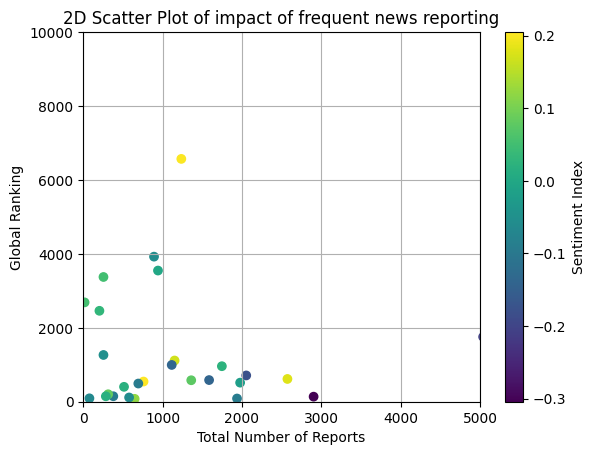

In [137]:
# The total number of reports by a website
ReportsByWebsite = merged_df['domain'].value_counts()

# Get all unique domains and their corresponding global ranking data
unique_domains = merged_df[['domain', 'global_rank']].drop_duplicates()

plt.scatter(merged_df['domain'].value_counts(), unique_domains['global_rank'], c=average_sentiment ,cmap='viridis')  
plt.xlabel('Total Number of Reports')
plt.title('2D Scatter Plot of impact of frequent news reporting')
plt.colorbar(label='Sentiment Index')
plt.ylabel('Global Ranking')
plt.xlim(0, 5000)
plt.grid(True)
plt.ylim(0, 10000)

In [176]:
# Sort the DataFrame by 'global_rank' in ascending order
# sorted_df = 

# Get the top 10 websites with the highest numbers of visitor traffic
# top_websites = sorted_df['source_name'].value_counts().head(10)

# print('Top 10 websites with the highest numbers of visitor traffic:')
# print(sorted_df)

merged_df.sort_values('global_rank')[['source_name', 'global_rank']].groupby('source_name').first().sort_values('global_rank').head(10)

global_rank
source_name                  
Forbes                     64
CNN                        78
BBC News                   87
Business Insider          115
Time                      137
NPR                       147
Wired                     148
The Verge                 202
Gizmodo.com               403
GlobeNewswire             492